# Credit Risk Resampling Techniques

In [1]:
# Set warning messages Off (Ignore)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import libraries
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

# Imabalance libraries
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTEENN

# Read the CSV and Perform Basic Data Cleaning
Basically telling the code I'll only work with this columns from the dataset

In [3]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [4]:
# Load the data
file_path = Path('LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


# Split the Data into Training and Testing

In [5]:
# Before we split the data, lets' convert the string values into numerical ones using get_dummies() method

In [6]:
# Identify string variables by their data type
# We don't want to convert them all here, loan_status will be used as our target, so we will convert later
getStringFields = df.select_dtypes(include='object').columns
print(getStringFields)

Index(['home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'initial_list_status', 'next_pymnt_d', 'application_type',
       'hardship_flag', 'debt_settlement_flag'],
      dtype='object')


In [7]:
# Let's create all features by leaving loan_status as our target
# Create our features
X = df.drop(columns='loan_status')

# Review X
X

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,dti,delinq_2yrs,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,n,27.24,0.0,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,n,20.23,0.0,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,n,24.26,0.0,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,n,31.44,0.0,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,n,18.76,0.0,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68812,10000.0,0.1502,346.76,RENT,26000.0,Source Verified,Jan-2019,n,9.60,0.0,...,80.0,0.0,0.0,0.0,20625.0,6798.0,11300.0,5425.0,N,N
68813,12000.0,0.2727,368.37,RENT,63000.0,Not Verified,Jan-2019,n,29.07,0.0,...,96.2,0.0,0.0,0.0,87939.0,60350.0,13500.0,62939.0,N,N
68814,5000.0,0.1992,185.62,MORTGAGE,52000.0,Source Verified,Jan-2019,n,14.86,0.0,...,100.0,0.0,1.0,0.0,30592.0,18611.0,3600.0,18492.0,N,N
68815,40000.0,0.0646,1225.24,MORTGAGE,520000.0,Verified,Jan-2019,n,9.96,0.0,...,98.2,12.5,0.0,0.0,1033574.0,95958.0,100800.0,78634.0,N,N


In [8]:
# Current shape
X.shape

(68817, 85)

In [9]:
# Now that we have droped loan_status, lets convert all string data types
X = pd.get_dummies(data=X)

# After conversion shape
X.shape

(68817, 95)

In [10]:
# Final dataframe structure
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68817 entries, 0 to 68816
Data columns (total 95 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            68817 non-null  float64
 1   int_rate                             68817 non-null  float64
 2   installment                          68817 non-null  float64
 3   annual_inc                           68817 non-null  float64
 4   dti                                  68817 non-null  float64
 5   delinq_2yrs                          68817 non-null  float64
 6   inq_last_6mths                       68817 non-null  float64
 7   open_acc                             68817 non-null  float64
 8   pub_rec                              68817 non-null  float64
 9   revol_bal                            68817 non-null  float64
 10  total_acc                            68817 non-null  float64
 11  out_prncp                   

In [11]:
# Describe X df
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.381873,0.0,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [12]:
# Create our target
y = df['loan_status']

# Review resulting df
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [13]:
# Split our data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

In [14]:
# Print training target value counts
y_train.value_counts()

low_risk     51366
high_risk      246
Name: loan_status, dtype: int64

In [15]:
# Print testing target value counts
y_test.value_counts()

low_risk     17104
high_risk      101
Name: loan_status, dtype: int64

# Evaluate initial performance
### Use a LogisticRegression model first

In [16]:
# Set classifier as a LogisticRegression model
model = LogisticRegression(solver='lbfgs', random_state=1)
model

LogisticRegression(random_state=1)

In [17]:
# Now lets train our model
model.fit(X_train, y_train)

LogisticRegression(random_state=1)

In [18]:
# Use Counter to count the samples
Counter(y_train)

Counter({'low_risk': 51366, 'high_risk': 246})

In [19]:
# Create predictions
predictions = model.predict(X_test)
# Add predictions to a DataFrame
pd.DataFrame({"Prediction": predictions, "Actual": y_test})

,Prediction,Actual
7034,low_risk,low_risk
38804,low_risk,low_risk
65533,low_risk,low_risk
37736,low_risk,low_risk
6390,low_risk,low_risk
...,...,...
31854,low_risk,low_risk
27835,low_risk,low_risk
3089,low_risk,low_risk
43343,low_risk,low_risk


In [20]:
# See counts
pd.DataFrame({"Prediction": predictions, "Actual": y_test}).value_counts()

Prediction  Actual   
low_risk    low_risk     17102
            high_risk      100
high_risk   low_risk         2
            high_risk        1
dtype: int64

In [21]:
# Validate the model
accuracy_score(y_test, predictions)

0.9940714908456844

The model achived an accuracy of 0.99, meaning that almost every single observation was predicted correctly, but it looks like there is an imbalance problem as there are "many" __low_risk__ loans to accurately predict loan's reisk.

### Confusion Matrix
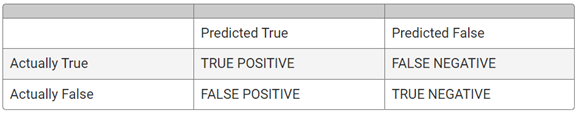

In [22]:
# Now lets create a confusion matrix
matrix = confusion_matrix(y_test, predictions)
print(matrix)

[[    1   100]
 [    2 17102]]


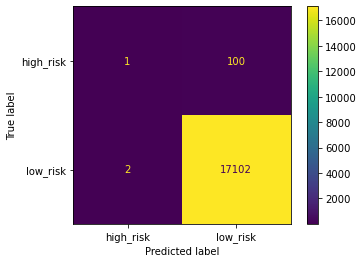

In [23]:
# Lets do a better visualization as suggested by the instructor
DisplayMatrix = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=model.classes_)
DisplayMatrix.plot()

In [24]:
# Generate the classification Report
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

   high_risk       0.33      0.01      0.02       101
    low_risk       0.99      1.00      1.00     17104

    accuracy                           0.99     17205
   macro avg       0.66      0.50      0.51     17205
weighted avg       0.99      0.99      0.99     17205



The `Classification Report` shows we can't predict __high risk__ accurately loans with the data as it is.

### Understanding a Classification Report
https://medium.com/@kohlishivam5522/understanding-a-classification-report-for-your-machine-learning-model-88815e2ce397

In [25]:
# Show the imbalanced Callssification Report
report2 = classification_report_imbalanced(y_test, predictions)
print(report2)

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.33      0.01      1.00      0.02      0.10      0.01       101
   low_risk       0.99      1.00      0.01      1.00      0.10      0.01     17104

avg / total       0.99      0.99      0.02      0.99      0.10      0.01     17205



# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [26]:
# Resample the training data with the RandomOversampler
# Create the Model
resampled = RandomOverSampler(random_state=1)

In [27]:
# Fit/Train our model
X_resampled, y_resampled = resampled.fit_resample(X_train, y_train)

In [28]:
# Use Counter to count the samples
Counter(y_resampled)

Counter({'low_risk': 51366, 'high_risk': 51366})

In [29]:
# Repeat the process using the resampled data
model2 = LogisticRegression(solver='lbfgs', random_state=1)
model2.fit(X_resampled, y_resampled)
predictions2 = model2.predict(X_resampled)
pd.DataFrame({"Resampled Prediction": predictions2, "Resampled Actual": y_resampled})

,Resampled Prediction,Resampled Actual
0,high_risk,low_risk
1,low_risk,low_risk
2,high_risk,low_risk
3,low_risk,low_risk
4,low_risk,low_risk
...,...,...
102727,high_risk,high_risk
102728,high_risk,high_risk
102729,high_risk,high_risk
102730,high_risk,high_risk


In [30]:
# See counts
pd.DataFrame({"Resampled Prediction": predictions2, "Resampled Actual": y_resampled}).value_counts()

Resampled Prediction  Resampled Actual
high_risk             high_risk           35242
low_risk              low_risk            33282
high_risk             low_risk            18084
low_risk              high_risk           16124
dtype: int64

In [31]:
# Validate the model
accuracy_score(y_resampled, predictions2)

0.6670170930187284

In [32]:
# Now lets create a confusion matrix
matrix2 = confusion_matrix(y_resampled, predictions2)
print(matrix2)

[[35242 16124]
 [18084 33282]]


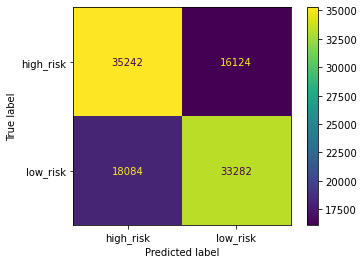

In [33]:
# Now lets create a ConfusionMatrixDisplay, to better visualize the results
DisplayMatrix2 = ConfusionMatrixDisplay(confusion_matrix=matrix2, display_labels=model2.classes_)
DisplayMatrix2.plot()

In [34]:
# Generate the Classification Report
report3 = classification_report(y_resampled, predictions2)
print(report3)

              precision    recall  f1-score   support

   high_risk       0.66      0.69      0.67     51366
    low_risk       0.67      0.65      0.66     51366

    accuracy                           0.67    102732
   macro avg       0.67      0.67      0.67    102732
weighted avg       0.67      0.67      0.67    102732



In [35]:
# Generate the Imbalanced Classification Report
report4 = classification_report_imbalanced(y_resampled, predictions2)
print(report4)

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.66      0.69      0.65      0.67      0.67      0.45     51366
   low_risk       0.67      0.65      0.69      0.66      0.67      0.44     51366

avg / total       0.67      0.67      0.67      0.67      0.67      0.44    102732



### SMOTE Oversampling

In [36]:
# Resample the training data with SMOTE
# Create the Model
resampled2 = SMOTE(random_state=1, sampling_strategy='auto')

In [37]:
# Fit/Train our model
X_resampled2, y_resampled2 = resampled2.fit_resample(X_train, y_train)

In [38]:
# Use Counter to count the samples
Counter(y_resampled2)

Counter({'low_risk': 51366, 'high_risk': 51366})

In [39]:
# Repeat the process using the resampled data
model3 = LogisticRegression(solver='lbfgs', random_state=1)
model3.fit(X_resampled2, y_resampled2)
predictions3 = model3.predict(X_resampled2)
pd.DataFrame({"Resampled Prediction": predictions3, "Resampled Actual": y_resampled2})

,Resampled Prediction,Resampled Actual
0,high_risk,low_risk
1,low_risk,low_risk
2,high_risk,low_risk
3,low_risk,low_risk
4,low_risk,low_risk
...,...,...
102727,high_risk,high_risk
102728,high_risk,high_risk
102729,high_risk,high_risk
102730,high_risk,high_risk


In [40]:
# Validate the model
accuracy_score(y_resampled2, predictions3)

0.6425651208970915

In [41]:
# Now lets create a confusion matrix
matrix3 = confusion_matrix(y_resampled2, predictions3)
print(matrix3)

[[30372 20994]
 [15726 35640]]


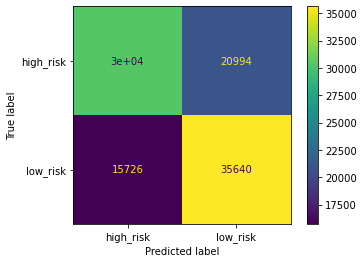

In [42]:
# Now lets create a ConfusionMatrixDisplay, to better visualize the results
DisplayMatrix3 = ConfusionMatrixDisplay(confusion_matrix=matrix3, display_labels=model3.classes_)
DisplayMatrix3.plot()

In [43]:
# Generate the Classification Report
report5 = classification_report(y_resampled2, predictions3)
print(report5)

              precision    recall  f1-score   support

   high_risk       0.66      0.59      0.62     51366
    low_risk       0.63      0.69      0.66     51366

    accuracy                           0.64    102732
   macro avg       0.64      0.64      0.64    102732
weighted avg       0.64      0.64      0.64    102732



In [44]:
# Generate the Imbalanced Classification Report
report6 = classification_report_imbalanced(y_resampled2, predictions3)
print(report6)

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.66      0.59      0.69      0.62      0.64      0.41     51366
   low_risk       0.63      0.69      0.59      0.66      0.64      0.41     51366

avg / total       0.64      0.64      0.64      0.64      0.64      0.41    102732



# Undersampling

In this section, you will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [45]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete
# Create the Model
resampled3 = ClusterCentroids(random_state=1, sampling_strategy='auto')

In [46]:
# Fit/Train our model
X_resampled3, y_resampled3 = resampled3.fit_resample(X_train, y_train)

In [47]:
# Use Counter to count the samples
Counter(y_resampled3)

Counter({'high_risk': 246, 'low_risk': 246})

In [48]:
# Repeat the process using the resampled data
model4 = LogisticRegression(solver='lbfgs', random_state=1)
model4.fit(X_resampled3, y_resampled3)
predictions4 = model4.predict(X_resampled3)
pd.DataFrame({"Resampled Prediction": predictions4, "Resampled Actual": y_resampled3})

,Resampled Prediction,Resampled Actual
0,low_risk,high_risk
1,high_risk,high_risk
2,high_risk,high_risk
3,high_risk,high_risk
4,high_risk,high_risk
...,...,...
487,low_risk,low_risk
488,low_risk,low_risk
489,low_risk,low_risk
490,high_risk,low_risk


In [49]:
# Validate the model
accuracy_score(y_resampled3, predictions4)

0.6666666666666666

In [50]:
# Now lets create a confusion matrix
matrix4 = confusion_matrix(y_resampled3, predictions4)
print(matrix4)

[[157  89]
 [ 75 171]]


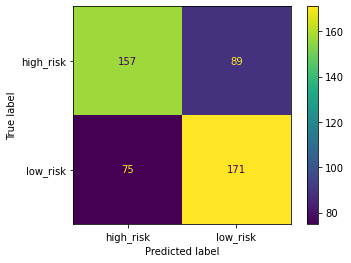

In [51]:
# Now lets create a ConfusionMatrixDisplay, to better visualize the results
DisplayMatrix4 = ConfusionMatrixDisplay(confusion_matrix=matrix4, display_labels=model4.classes_)
DisplayMatrix4.plot()

In [52]:
# Generate the Classification Report
report7 = classification_report(y_resampled3, predictions4)
print(report7)

              precision    recall  f1-score   support

   high_risk       0.68      0.64      0.66       246
    low_risk       0.66      0.70      0.68       246

    accuracy                           0.67       492
   macro avg       0.67      0.67      0.67       492
weighted avg       0.67      0.67      0.67       492



In [53]:
# Generate the Imbalanced Classification Report
report8 = classification_report_imbalanced(y_resampled3, predictions4)
print(report8)

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.68      0.64      0.70      0.66      0.67      0.44       246
   low_risk       0.66      0.70      0.64      0.68      0.67      0.45       246

avg / total       0.67      0.67      0.67      0.67      0.67      0.44       492



# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [54]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete
# Create the Model
resampled4 = SMOTEENN(random_state=1)

In [55]:
# Fit/Train our model
X_resampled4, y_resampled4 = resampled4.fit_resample(X_train, y_train)

In [56]:
# Use Counter to count the samples
Counter(y_resampled4)

Counter({'high_risk': 51361, 'low_risk': 46653})

In [57]:
# Repeat the process using the resampled data
model5 = LogisticRegression(solver='lbfgs', random_state=1)
model5.fit(X_resampled4, y_resampled4)
predictions5 = model5.predict(X_resampled4)
pd.DataFrame({"Resampled Prediction": predictions5, "Resampled Actual": y_resampled4})

,Resampled Prediction,Resampled Actual
0,low_risk,high_risk
1,high_risk,high_risk
2,high_risk,high_risk
3,low_risk,high_risk
4,high_risk,high_risk
...,...,...
98009,low_risk,low_risk
98010,low_risk,low_risk
98011,high_risk,low_risk
98012,low_risk,low_risk


In [58]:
# Validate the model
accuracy_score(y_resampled4, predictions5)

0.6608137612994062

In [59]:
# Now lets create a confusion matrix
matrix5 = confusion_matrix(y_resampled4, predictions5)
print(matrix5)

[[37044 14317]
 [18928 27725]]


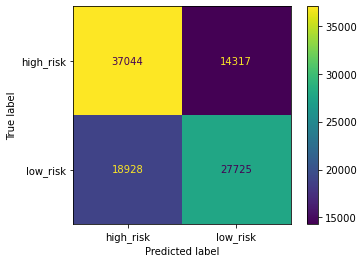

In [60]:
# Now lets create a ConfusionMatrixDisplay, to better visualize the results
DisplayMatrix5 = ConfusionMatrixDisplay(confusion_matrix=matrix5, display_labels=model5.classes_)
DisplayMatrix5.plot()

In [61]:
# Generate the Classification Report
report9 = classification_report(y_resampled4, predictions5)
print(report9)

              precision    recall  f1-score   support

   high_risk       0.66      0.72      0.69     51361
    low_risk       0.66      0.59      0.63     46653

    accuracy                           0.66     98014
   macro avg       0.66      0.66      0.66     98014
weighted avg       0.66      0.66      0.66     98014



In [62]:
# Generate the Imbalanced Classification Report
report10 = classification_report_imbalanced(y_resampled4, predictions5)
print(report10)

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.66      0.72      0.59      0.69      0.65      0.43     51361
   low_risk       0.66      0.59      0.72      0.63      0.65      0.42     46653

avg / total       0.66      0.66      0.65      0.66      0.65      0.43     98014

